In [1]:
import pandas as pd
from math import pi, sin
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_trc.csv')

In [3]:
sine_m = []
sine_y = []

for i in range(0, 30):
    sine_m.append(0.5 * sin(i * pi / 14.5) + 0.5)

for i in range(0, 365):
    sine_y.append(0.5 * sin(i * pi / 182.5) + 0.5)

In [4]:
sales = {}
sine350x = sine_m * 350 
sine4x = sine_y * 4 

for i in range(len(df)):
    if df['date'][i] in list(sales.keys()):
        sales[df['date'][i]] += df['sales'][i]
    else:
        sales[df['date'][i]] = df['sales'][i]

sales = pd.DataFrame({'dates': list(sales.keys()), 'sine_y': sine4x[:len(sales.keys())], 
                        'sine_m': sine350x[:len(sales.keys())], 'sales': [sales[k] for k in list(sales.keys())]})

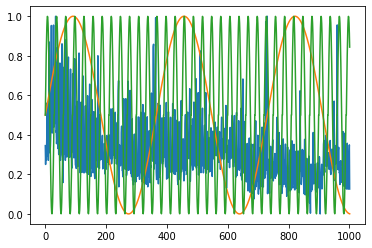

In [5]:
MAX = max(sales['sales'])
MIN = min(sales['sales'])
sales_norm = sales.copy()
sales_norm['sales'] = (sales_norm['sales'] - MIN) / (MAX - MIN)

plt.plot(sales_norm['sales'])
plt.plot(sales['sine_y'])
plt.plot(sales['sine_m'])
plt.show()

In [6]:
length = 1
time_series = TimeseriesGenerator([[sales_norm['sales'][i - 1], sales['sine_y'][i], sales['sine_m'][i]]  for i in range(1, len(sales))], 
                                    sales_norm['sales'][1:], length=length, batch_size=len(sales_norm))
input, target = time_series[0]

print(input.shape)
print(target.shape)

train_portion = 0.7
tp = int(train_portion * len(input))

input_t = input[:tp]
input_v = input[tp:]

target_t = target[:tp]
target_v = target[tp:]

(1000, 1, 3)
(1000,)


Epoch 1/200
234/234 [==============================] - 1s 5ms/step - loss: 0.1948 - mean_absolute_error: 0.3105 - val_loss: 0.0144 - val_mean_absolute_error: 0.0796
Epoch 2/200
234/234 [==============================] - 1s 5ms/step - loss: 0.0387 - mean_absolute_error: 0.1477 - val_loss: 0.0148 - val_mean_absolute_error: 0.0880
Epoch 3/200
234/234 [==============================] - 1s 6ms/step - loss: 0.0323 - mean_absolute_error: 0.1318 - val_loss: 0.0140 - val_mean_absolute_error: 0.0852
Epoch 4/200
234/234 [==============================] - 1s 6ms/step - loss: 0.0276 - mean_absolute_error: 0.1209 - val_loss: 0.0153 - val_mean_absolute_error: 0.0915
Epoch 5/200
234/234 [==============================] - 1s 5ms/step - loss: 0.0245 - mean_absolute_error: 0.1150 - val_loss: 0.0168 - val_mean_absolute_error: 0.0981
Epoch 6/200
234/234 [==============================] - 1s 5ms/step - loss: 0.0228 - mean_absolute_error: 0.1102 - val_loss: 0.0165 - val_mean_absolute_error: 0.0975
Epoch 7/20

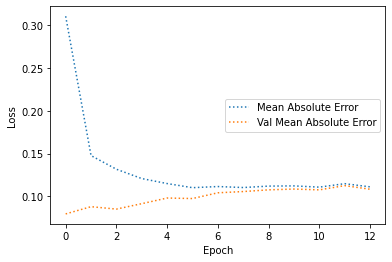

In [7]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1, 3)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
history = model.fit(input_t, target_t, batch_size=3, epochs=200, 
                    shuffle=False, validation_data=(input_v, target_v), 
                    callbacks=[earlyStop])

plt.plot(history.history['mean_absolute_error'], ':', label='Mean Absolute Error')
plt.plot(history.history['val_mean_absolute_error'], ':', label='Val Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='right')
plt.show()

In [8]:
def predict(model, date, MAX, MIN):
    d = date[:2]
    m = date[2:4]
    y = date[4:]
    october1st = 274

    last_sale = [[sales_norm['sales'].iloc[-1]]]
    sine_y_pred = sales['sine_y'][october1st + int(d) - 1]
    sine_m_pred = sales['sine_m'][int(d) - 1]

    for _ in range(int(d)):
        last_sale = model.predict([[float(last_sale[0][0]), sine_y_pred, sine_m_pred]])

    return (last_sale[0][0] * (MAX - MIN) + MIN)

In [10]:
print(predict(model, '21102019', MAX, MIN))

731.756384666443


In [11]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model\assets
